**IMPORTANT NOTE TO RUN THE APPLICATION**

If the current version of Keras is not updated and the code is giving an error because of that, the command below should be executed to updated the Keras version then runtime should be restarted

**pip install -U keras**

In [3]:
pip install -U keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
import pandas as pd

## Importing the dataset

In [0]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)

In [6]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
data.count()

article_link    26709
headline        26709
is_sarcastic    26709
dtype: int64

In [8]:
print(data.isnull().any(axis = 0))

article_link    False
headline        False
is_sarcastic    False
dtype: bool


## WordCloud

In [9]:
pip install wordcloud

In [0]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)



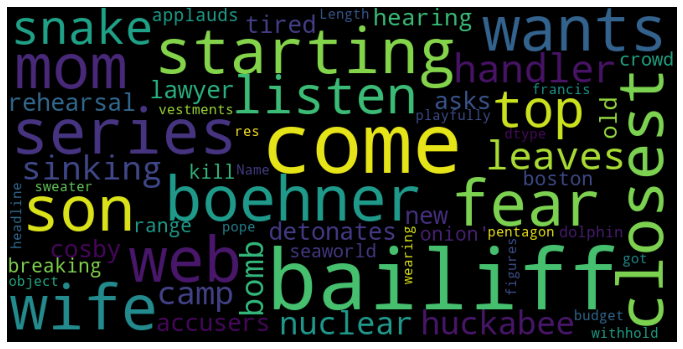

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=(12, 7))
plt.axis("off")
wordcloud.generate(str(data.loc[data['is_sarcastic'] == 1, 'headline']))
plt.imshow(wordcloud);

## Data Preprocessing

In [0]:
import re
data['headline'] = data['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [13]:
data['headline'].head()

0    former versace store clerk sues over secret  b...
1    the  roseanne  revival catches up to our thorn...
2    mom starting to fear son s web series closest ...
3    boehner just wants wife to listen  not come up...
4    j k  rowling wishes snape happy birthday in th...
Name: headline, dtype: object

In [0]:
# getting features and labels:
features = data['headline']
labels = data['is_sarcastic']

In [0]:
# Stemming our data
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [0]:
# vectorizing the data with maximum of 5000 features
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

In [17]:
print(features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# Latent Semantic Analysis
lsa= TruncatedSVD(n_components=500, n_iter=10,random_state=5)
tr= lsa.fit(features)
X_tr= tr.transform(features)

In [0]:
Y = pd.get_dummies(data['is_sarcastic']).values

In [20]:
X_tr.shape

(26709, 500)

## Splitting  the Datset

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, data["is_sarcastic"], test_size=0.2, random_state=50)
print(len(X_train), len(y_train), len(X_val), len(y_val))

21367 21367 5342 5342


## Random Forest, Decsision Tree, Logistic Regression, SVM, Neural Network

In [0]:
model_dict = {'Random Forest': RandomForestClassifier(n_estimators = 1000, random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'Logistic Regression': LogisticRegression(random_state=3),
              'SVM': svm.LinearSVC(),
              'Neural Network': MLPClassifier(hidden_layer_sizes=(1,1,1), alpha= 0.001, max_iter=500, solver='sgd', learning_rate='adaptive') 
              }

def model_df(model_dict, X_train, y_train):
    model=[]
    for i,j in model_dict.items():
        j.fit(X_train, y_train)
        model.append(j)
    return model

In [23]:
models=model_df(model_dict, X_train, y_train)
print(models)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best'), LogisticRegression(C=1.0, cl

In [0]:
name= model_dict.keys()

zip_eval = zip(model_dict,models)
eval_model = dict(zip_eval)

def evaluation(models):
    model_name, accuracyscore, pscore, rscore, f1score = [], [], [], [], []
    for name,model in eval_model.items():   
        model_name.append(name)
        y_pred = model.predict(X_val)
        accuracyscore.append(round((accuracy_score(y_val, y_pred)*100),2))
        pscore.append(round((precision_score(y_val, y_pred, average='macro')*100),2))
        rscore.append(round((recall_score(y_val, y_pred, average='macro')*100),2))
        f1score.append(round((f1_score(y_val, y_pred, average='macro')*100),2))
        modelcomparison = pd.DataFrame([model_name, accuracyscore, pscore, rscore, f1score]).T
        modelcomparison.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
    return modelcomparison



In [0]:
def train_evaluation(models):
    model_name, accuracyscore, pscore, rscore, f1score = [], [], [], [], []
    for name,model in eval_model.items():   
        model_name.append(name)
        y_pred = model.predict(X_train)
        accuracyscore.append((accuracy_score(y_train, y_pred))*100)
        pscore.append(precision_score(y_train, y_pred, average='macro'))
        rscore.append(recall_score(y_train, y_pred, average='macro'))
        f1score.append(f1_score(y_train, y_pred, average='macro'))
        modelcomparison = pd.DataFrame([model_name, accuracyscore, pscore, rscore, f1score]).T
        modelcomparison.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
    return modelcomparison

**Train Evaluation**

In [26]:
train_evaluation(eval_model)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Random Forest,99.9813,0.999787,0.999833,0.99981
1,Decsision Tree,99.9813,0.999787,0.999833,0.99981
2,Logistic Regression,81.682,0.814126,0.81398,0.814052
3,SVM,81.8739,0.815909,0.816681,0.816272
4,Neural Network,56.0537,0.280269,0.5,0.359195


**Test Evaluation**

In [27]:
 evaluation(eval_model)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Random Forest,78,77.88,77.15,77.39
1,Decsision Tree,64.71,64.13,64.12,64.13
2,Logistic Regression,80.55,80.24,80.2,80.22
3,SVM,80.4,80.08,80.13,80.1
4,Neural Network,56.31,28.15,50,36.02


## LSTM

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re


Using TensorFlow backend.


**Tokenizer**

In [0]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['headline'].values)
X = tokenizer.texts_to_sequences(data['headline'].values)
X = pad_sequences(X)

In [30]:
Y = pd.get_dummies(data['is_sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17895, 28) (17895, 2)
(8814, 28) (8814, 2)


**Defining model**

In [0]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

**Training the model**

In [32]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, validation_split=0.1, verbose = 2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16105 samples, validate on 1790 samples
Epoch 1/10
 - 52s - loss: 0.4597 - accuracy: 0.7742 - val_loss: 0.3559 - val_accuracy: 0.8464
Epoch 2/10
 - 50s - loss: 0.3447 - accuracy: 0.8492 - val_loss: 0.3430 - val_accuracy: 0.8564
Epoch 3/10
 - 51s - loss: 0.3048 - accuracy: 0.8717 - val_loss: 0.3495 - val_accuracy: 0.8492
Epoch 4/10
 - 50s - loss: 0.2750 - accuracy: 0.8853 - val_loss: 0.3653 - val_accuracy: 0.8547
Epoch 5/10
 - 51s - loss: 0.2523 - accuracy: 0.8920 - val_loss: 0.3813 - val_accuracy: 0.8447
Epoch 6/10
 - 51s - loss: 0.2344 - accuracy: 0.9029 - val_loss: 0.4034 - val_accuracy: 0.8486
Epoch 7/10
 - 50s - loss: 0.2163 - accuracy: 0.9102 - val_loss: 0.4116 - val_accuracy: 0.8458
Epoch 8/10
 - 51s - loss: 0.1981 - accuracy: 0.9197 - val_loss: 0.4307 - val_accuracy: 0.8363
Epoch 9/10
 - 50s - loss: 0.1859 - accuracy: 0.9252 - val_loss: 0.4653 - val_accuracy: 0.8341
Epoch 10/10
 - 51s - loss: 0.1702 - accuracy: 0.9298 - val_loss: 0.5190 - val_accuracy: 0.8346


In [0]:
score,acc=model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

In [34]:
print(score)
print(acc)

0.535754139099582
0.8236895799636841


In [0]:
model.save('group2_project_2_TT_LSTM.h5')

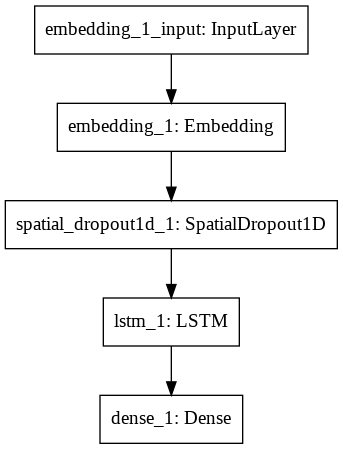

In [36]:

from keras.utils import plot_model
plot_model(model, to_file='model.png')

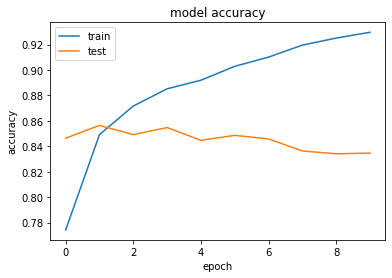

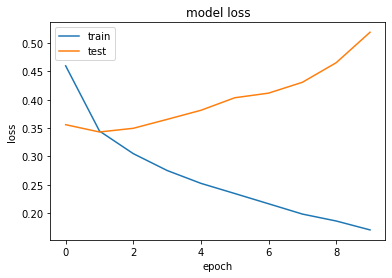

<Figure size 432x288 with 0 Axes>

In [37]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [38]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("Sarcasm_acc", pos_correct/pos_cnt*100, "%")
print("Non-Sarcasm_acc", neg_correct/neg_cnt*100, "%")

Sarcasm_acc 78.97698209718669 %
Non-Sarcasm_acc 85.07340946166396 %


In [39]:
headline = ['drunk driver in the zone']
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=28, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("sarcastic")

sarcastic


## CNN MODEL

In [40]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(17895, 28)
(17895, 2)
(8814, 28)
(8814, 2)


In [0]:

from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras import regularizers

cnn_model = Sequential()
max_features = 20000
sequence_length = 28

# Input / Embdedding
cnn_model.add(Embedding(max_features, 300, input_length=sequence_length,trainable=True))

# CNN

cnn_model.add(SpatialDropout1D(0.2))

cnn_model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(Dropout(rate = 0.50))
cnn_model.add(MaxPooling1D(pool_size=2))


cnn_model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())

# Output layer
cnn_model.add(Dense(2, activation='sigmoid'))

In [0]:
# compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

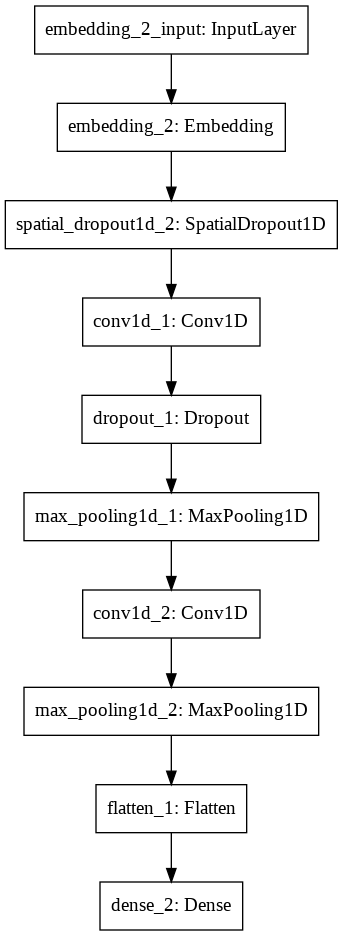

In [43]:
from keras.utils import plot_model
plot_model(cnn_model, to_file='model1.png')

In [44]:
history = cnn_model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=1, validation_split=0.1, shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16105 samples, validate on 1790 samples
Epoch 1/10
16105/16105 [==============================] - 7s 428us/step - loss: 0.4880 - acc: 0.7425 - val_loss: 0.3720 - val_acc: 0.8419
Epoch 2/10
16105/16105 [==============================] - 2s 121us/step - loss: 0.3397 - acc: 0.8530 - val_loss: 0.3587 - val_acc: 0.8469
Epoch 3/10
16105/16105 [==============================] - 2s 120us/step - loss: 0.2985 - acc: 0.8748 - val_loss: 0.3488 - val_acc: 0.8464
Epoch 4/10
16105/16105 [==============================] - 2s 120us/step - loss: 0.2636 - acc: 0.8889 - val_loss: 0.3519 - val_acc: 0.8458
Epoch 5/10
16105/16105 [==============================] - 2s 122us/step - loss: 0.2270 - acc: 0.9063 - val_loss: 0.3759 - val_acc: 0.8402
Epoch 6/10
16105/16105 [==============================] - 2s 121us/step - loss: 0.2001 - acc: 0.9197 - val_loss: 0.3900 - val_acc: 0.8453
Epoch 7/10
16105/16105 [==============================] - 2s 121us/step - loss: 0.1718 - acc: 0.9336 - val_loss: 0.4265 - v

In [45]:
scores=cnn_model.evaluate(X_test,Y_test,verbose=1)

8814/8814 [==============================] - 1s 80us/step


In [46]:
print("Loss")
print(scores[0])
print("Accuracy")
print(scores[1])

Loss
0.5310194972511156
Accuracy
0.8283412456512451


In [0]:
model.save('group2_project_2_TT_CNN.h5')

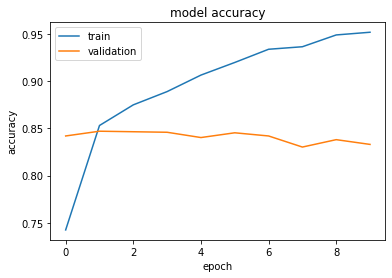

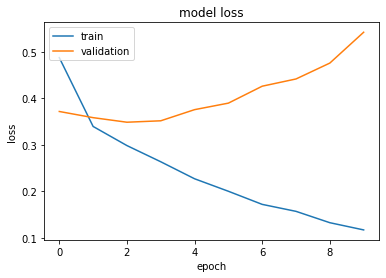

In [48]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()